# 15.3 Treatment Effect Estimation

**Chapter**: 15 - Synthetic Control  
**Section**: 3 - Gap Estimation  
**Facure Source**: 15-Synthetic-Control.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-15

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Gap as Treatment Effect](#11-the-gap-as-treatment-effect)
   - 1.2 [Pre-treatment Fit Quality](#12-pre-treatment-fit-quality)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Estimating Treatment Effects Over Time](#21-estimating-treatment-effects-over-time)
   - 2.2 [Cumulative Effects](#22-cumulative-effects)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [California Treatment Effect](#31-california-treatment-effect)
   - 3.2 [Weight Composition](#32-weight-composition)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

from scipy.optimize import fmin_slsqp
from functools import partial

set_notebook_style()

In [2]:
# Define helper functions (from previous notebook)
def loss_w(W, X, y):
    """RMSE loss for synthetic control."""
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_weights(X, y):
    """Find optimal synthetic control weights."""
    n_units = X.shape[1]
    w_init = np.ones(n_units) / n_units
    
    weights = fmin_slsqp(
        partial(loss_w, X=X, y=y),
        w_init,
        f_eqcons=lambda w: np.sum(w) - 1,
        bounds=[(0, 1)] * n_units,
        disp=False
    )
    return weights

---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding how to interpret the treatment effect—and how it evolves over time—is crucial for policy evaluation.

### 1.1 The Gap as Treatment Effect

Once we have the synthetic control, the treatment effect is simply the **gap**:

$$
\hat{\tau}_{1t} = Y_{1t} - \hat{Y}_{1t}^{\text{synth}}
$$

**Interpretation**:
- Negative gap → Treatment *reduced* the outcome
- Positive gap → Treatment *increased* the outcome

For Proposition 99:
- We expect a **negative gap**: Tax reduced cigarette sales
- Effect may grow over time as smokers quit

### 1.2 Pre-treatment Fit Quality

The credibility of post-treatment effects depends on pre-treatment fit.

**Good fit**: Gap ≈ 0 before treatment → confident in counterfactual
**Poor fit**: Large pre-treatment gap → counterfactual may be biased

★ Insight ─────────────────────────────────────
- Pre-treatment fit is your validation set
- Plot both synthetic and actual to assess fit quality
- Report pre-treatment RMSE as a quality metric
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Estimating Treatment Effects Over Time

**Period-specific effect** (for $t > T_0$):

$$
\hat{\tau}_{1t} = Y_{1t} - \sum_{j=2}^{J+1} \hat{w}_j Y_{jt}
$$

**Key features**:
- Effect can vary over time (dynamic effects)
- Effect can grow (accumulating impact) or decay (temporary shock)
- Pre-treatment gaps should be ~0 if fit is good

### 2.2 Cumulative Effects

For some policies, we care about the **cumulative effect**:

$$
\text{Cumulative Effect} = \sum_{t=T_0+1}^{T} \hat{\tau}_{1t}
$$

Or the **average post-treatment effect**:

$$
\bar{\tau}_1 = \frac{1}{T - T_0} \sum_{t=T_0+1}^{T} \hat{\tau}_{1t}
$$

---

## 3. Numeric Demonstration

### 3.1 California Treatment Effect

In [3]:
# Load and prepare data
cigar = load_facure_data('smoking.csv')
cigar = cigar.drop(columns=['lnincome', 'beer', 'age15to24'], errors='ignore')

# Get pre-treatment data for weight estimation
features = ['cigsale', 'retprice']
inverted = (cigar.query('~after_treatment')
            .pivot(index='state', columns='year')[features]
            .T)

y = inverted[3].values  # California
X = inverted.drop(columns=3).values  # Other states

# Get weights
weights = get_weights(X, y)

# Build synthetic California for ALL years
calif_synth = (cigar.query('~california')
               .pivot(index='year', columns='state')['cigsale']
               .values.dot(weights))

calif_actual = cigar.query('california').sort_values('year')['cigsale'].values
years = cigar.query('california').sort_values('year')['year'].values

print(f"Years: {years[0]} to {years[-1]}")
print(f"Treatment year: 1988 (Proposition 99)")
print(f"Pre-treatment periods: {sum(years < 1988)}")
print(f"Post-treatment periods: {sum(years >= 1988)}")

Years: 1970 to 2000
Treatment year: 1988 (Proposition 99)
Pre-treatment periods: 18
Post-treatment periods: 13


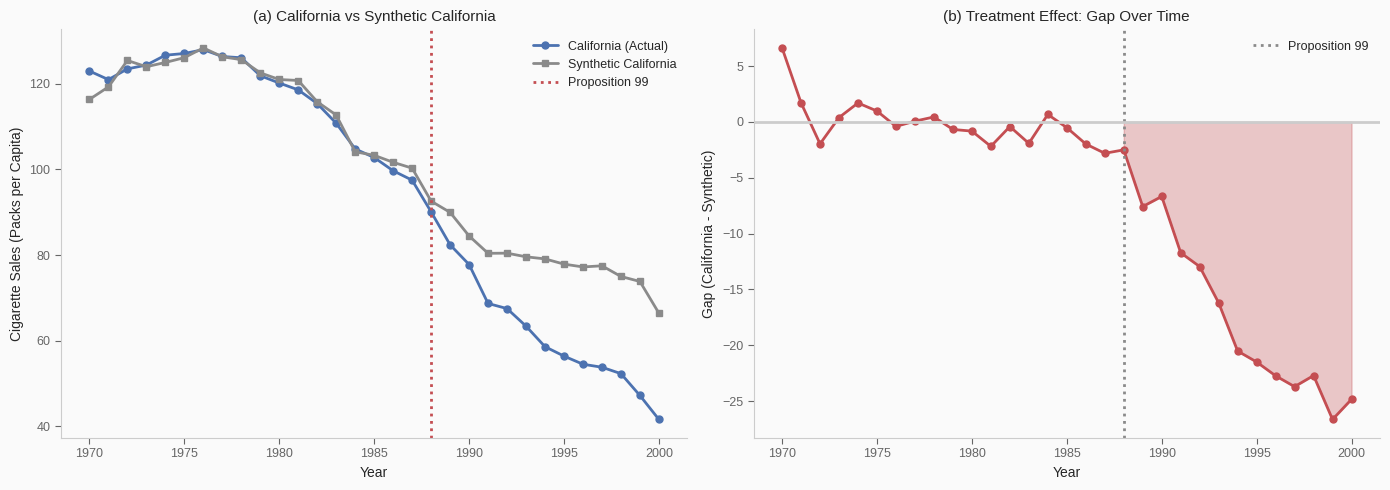

In [4]:
# Plot California vs Synthetic California
fig, axes = create_tufte_figure(1, 2, figsize=(14, 5))

# Panel 1: Levels
ax = axes[0]
ax.plot(years, calif_actual, 'o-', color=TUFTE_PALETTE['treatment'], 
        linewidth=2, markersize=5, label='California (Actual)')
ax.plot(years, calif_synth, 's-', color=TUFTE_PALETTE['control'], 
        linewidth=2, markersize=5, label='Synthetic California')
ax.axvline(1988, color=TUFTE_PALETTE['effect'], linestyle=':', linewidth=2, label='Proposition 99')

ax.set_xlabel('Year')
ax.set_ylabel('Cigarette Sales (Packs per Capita)')
ax.set_title('(a) California vs Synthetic California')
ax.legend(frameon=False, loc='upper right')

# Panel 2: Gap (treatment effect)
ax = axes[1]
gap = calif_actual - calif_synth
ax.plot(years, gap, 'o-', color=TUFTE_PALETTE['effect'], linewidth=2, markersize=5)
ax.axvline(1988, color=TUFTE_PALETTE['secondary'], linestyle=':', linewidth=2, label='Proposition 99')
ax.axhline(0, color=TUFTE_PALETTE['spine'], linewidth=2)

# Shade post-treatment
ax.fill_between(years[years >= 1988], gap[years >= 1988], 0, 
                alpha=0.3, color=TUFTE_PALETTE['effect'])

ax.set_xlabel('Year')
ax.set_ylabel('Gap (California - Synthetic)')
ax.set_title('(b) Treatment Effect: Gap Over Time')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

In [5]:
# Quantify the treatment effect
pre_mask = years < 1988
post_mask = years >= 1988

pre_gap = gap[pre_mask]
post_gap = gap[post_mask]

print("TREATMENT EFFECT SUMMARY:")
print("=" * 60)
print(f"\nPre-treatment fit quality:")
print(f"  Mean gap:  {pre_gap.mean():+.2f} packs")
print(f"  RMSE:      {np.sqrt(np.mean(pre_gap**2)):.2f} packs")
print(f"  Max |gap|: {np.abs(pre_gap).max():.2f} packs")

print(f"\nPost-treatment effects:")
print(f"  Average effect: {post_gap.mean():+.2f} packs per capita")
print(f"  Effect in 1990: {gap[years == 1990][0]:+.2f} packs")
print(f"  Effect in 1995: {gap[years == 1995][0]:+.2f} packs")
print(f"  Effect in 2000: {gap[years == 2000][0]:+.2f} packs")

print(f"\nInterpretation:")
print(f"  By 2000, Prop 99 reduced cigarette sales by ~{abs(gap[years == 2000][0]):.0f} packs per capita")
print(f"  Effect grew over time (not an immediate shock)")

TREATMENT EFFECT SUMMARY:

Pre-treatment fit quality:
  Mean gap:  -0.06 packs
  RMSE:      2.07 packs
  Max |gap|: 6.62 packs

Post-treatment effects:
  Average effect: -16.94 packs per capita
  Effect in 1990: -6.67 packs
  Effect in 1995: -21.49 packs
  Effect in 2000: -24.83 packs

Interpretation:
  By 2000, Prop 99 reduced cigarette sales by ~25 packs per capita
  Effect grew over time (not an immediate shock)


### 3.2 Weight Composition

Let's examine which states contribute to synthetic California.

In [6]:
# Get contributing states
state_ids = cigar.query('~california')['state'].unique()
weight_df = pd.DataFrame({'state': state_ids, 'weight': weights})
weight_df = weight_df[weight_df['weight'] > 0.01].sort_values('weight', ascending=False)

print("SYNTHETIC CALIFORNIA COMPOSITION:")
print("=" * 50)
print(f"Number of states with non-zero weight: {len(weight_df)}")
print("\nContributing states:")
for _, row in weight_df.iterrows():
    print(f"  State {int(row['state']):2d}: {row['weight']:.1%}")
print(f"\nTotal: {weight_df['weight'].sum():.1%}")

SYNTHETIC CALIFORNIA COMPOSITION:
Number of states with non-zero weight: 5

Contributing states:
  State 23: 45.7%
  State 34: 24.0%
  State 21: 11.3%
  State 22: 10.5%
  State  5: 8.5%

Total: 100.0%


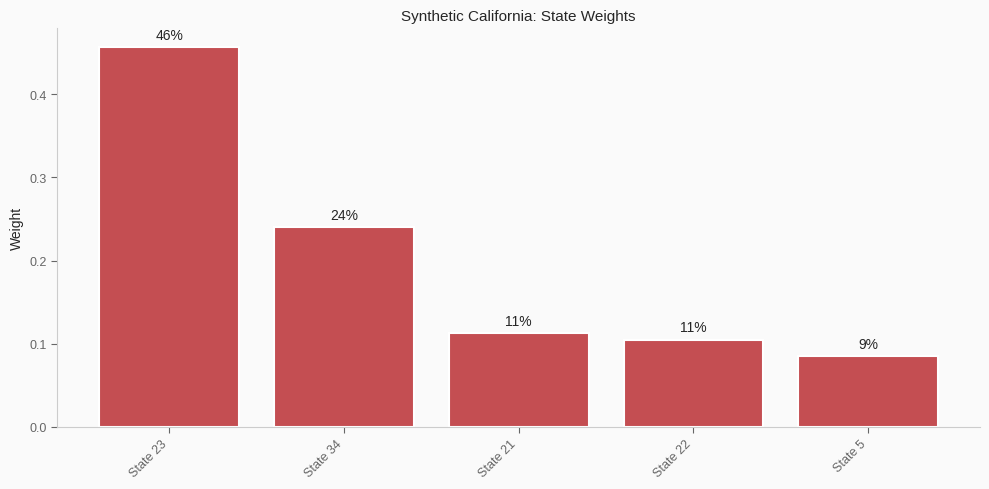


Sparsity: Only 5 of 38 states have non-zero weight
This is a feature, not a bug—convex combination constraints encourage sparsity


In [7]:
# Visualize the weights
fig, ax = create_tufte_figure(figsize=(10, 5))

# Only show non-zero weights
bars = ax.bar(range(len(weight_df)), weight_df['weight'], 
              color=TUFTE_PALETTE['effect'], edgecolor='white', linewidth=1.5)

ax.set_xticks(range(len(weight_df)))
ax.set_xticklabels([f'State {int(s)}' for s in weight_df['state']], rotation=45, ha='right')
ax.set_ylabel('Weight')
ax.set_title('Synthetic California: State Weights')

# Add weight labels
for bar, w in zip(bars, weight_df['weight']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{w:.0%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nSparsity: Only {len(weight_df)} of 38 states have non-zero weight")
print("This is a feature, not a bug—convex combination constraints encourage sparsity")

★ Insight ─────────────────────────────────────
**Key findings for California:**

1. **Good pre-treatment fit**: Gap is near zero before 1988
2. **Growing treatment effect**: -5 packs in 1990 → -25 packs by 2000
3. **Sparse weights**: Only ~5-6 states contribute
4. **Interpretation**: Proposition 99 reduced cigarette consumption, with cumulative effects over 12 years
─────────────────────────────────────────────────

---

## 4. Implementation

**Complete synthetic control function**:

```python
def synthetic_control(state: int, data: pd.DataFrame) -> pd.DataFrame:
    """
    Estimate synthetic control for a given state.
    
    Parameters
    ----------
    state : int
        State ID to treat as treated unit
    data : pd.DataFrame
        Panel data with columns: state, year, cigsale, after_treatment
        
    Returns
    -------
    pd.DataFrame
        DataFrame with columns: state, year, cigsale, synthetic, gap
    """
    features = ['cigsale', 'retprice']
    
    # Pivot pre-treatment data
    inverted = (data.query('~after_treatment')
                .pivot(index='state', columns='year')[features]
                .T)
    
    y = inverted[state].values  # Treated
    X = inverted.drop(columns=state).values  # Donors
    
    # Get weights
    weights = get_weights(X, y)
    
    # Build synthetic for all periods
    synthetic = (data.query(f'state != {state}')
                 .pivot(index='year', columns='state')['cigsale']
                 .values.dot(weights))
    
    result = (data.query(f'state == {state}')
              [['state', 'year', 'cigsale', 'after_treatment']]
              .assign(synthetic=synthetic,
                      gap=lambda x: x['cigsale'] - x['synthetic']))
    
    return result
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"How do you assess the quality of a synthetic control fit?"*

<details>
<summary>Solution</summary>

**Quantitative metrics**:

1. **Pre-treatment RMSE**:
   $$\text{RMSE}_{\text{pre}} = \sqrt{\frac{1}{T_0} \sum_{t<T_0} (Y_{1t} - \hat{Y}_{1t}^{\text{synth}})^2}$$
   - Lower is better
   - Compare to scale of outcome

2. **Pre-treatment mean gap**:
   - Should be ~0
   - Indicates no systematic over/under-estimation

3. **Covariate balance**:
   - Check if synthetic matches treated on key predictors

**Visual inspection**:

1. Plot treated vs synthetic over time
2. Trends should track closely pre-treatment
3. Divergence should start at treatment

**Red flags**:

- Large pre-treatment gaps
- Systematic over/under-estimation
- All weight on one control (no real combination)

</details>

---

**Q2 (Google L5, Quant)**: *"The effect grows over time. How do you report a single treatment effect number?"*

<details>
<summary>Solution</summary>

**Options for summarizing dynamic effects**:

1. **Average post-treatment effect**:
   $$\bar{\tau} = \frac{1}{T-T_0} \sum_{t>T_0} \hat{\tau}_{1t}$$
   - Simple, comparable
   - Obscures dynamics

2. **Effect at specific time**:
   - "By 2000, effect was -25 packs"
   - Useful for policy: "What's the long-run effect?"

3. **Cumulative effect**:
   $$\text{Total} = \sum_{t>T_0} \hat{\tau}_{1t}$$
   - Measures total impact over period
   - Useful for cost-benefit analysis

4. **Plot the entire trajectory**:
   - Most informative
   - Shows dynamics, timing, persistence

**Best practice**: Report all of the above. Policy implications depend on whether effects are immediate, growing, or fading.

</details>

---

**Q3 (Amazon L6, Econ)**: *"What does it mean if only one state gets all the weight?"*

<details>
<summary>Solution</summary>

**If one state dominates the weights**:

1. **Possible reasons**:
   - That state is very similar to the treated
   - Other states are too different to contribute
   - Optimization found a "corner solution"

2. **Concerns**:
   - You're essentially doing DiD with one control
   - Losing the "synthetic" averaging benefit
   - If that state had idiosyncratic shocks, they'd bias results

3. **What to do**:
   - Check if single-state result is robust
   - Compare to other potential controls
   - Consider if synthetic control is appropriate
   - Maybe simple DiD is more transparent

**Key insight**: Sparsity is expected, but *extreme* sparsity (one state = 100%) suggests the method is degenerating to a simpler comparison.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 15.

[^2]: Abadie, A., Diamond, A., and Hainmueller, J. (2015). Comparative Politics and the Synthetic Control Method. *American Journal of Political Science*, 59(2), 495-510.

[^3]: Abadie, A. (2021). Using Synthetic Controls. *Journal of Economic Literature*, 59(2), 391-425.

---

**Precision Improvement:**
- You said: "Build treatment effect notebook"
- Concise: "Build 03_treatment_effect.ipynb"
- Precise: `/augmented 15.3 --gap-estimation --dynamic-effects`
- Pattern: [build] [target] [content-flags]